In [1]:
# helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# our system imports
from aideme import *

%matplotlib inline

## Generating some data

We first generate some synthetic data for running experiments. In this regard, our system needs the following parameters: 

  - $X$: a $(N, dim)$ data matrix. It should stored as a numpy array.
  - $y$: a $(N, )$ numpy array representing the user labels for every data point, encoded as $0$ (negative) and $1$ (positive). Multi-class labels are not supported.

In the case of factorized algorithms, our system also needs two extra parameters:

  - $P$: a list of partitions, of size $K$. Each partition should be a list of column indexes in $X$ of attributes composing the subspace. 
  - $y_p$: a $(N, K)$ numpy array of partial labels, corresponding to the user labels for each subspace. These should be placed in a LabeledSet object, together with the final labels $y$.


In this example, our dataset is a uniformly random sample from the square $[-2, 2]^{dim}$. The positive region is also defined by a square $[-L, L]^{dim}$, with $L$ chosen to match the desired selectivity. 

selectivity : 0.105 %, #pos =  105.0


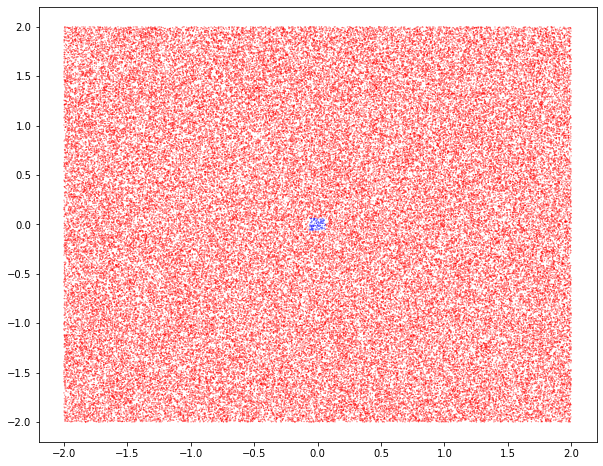

In [2]:
# DUMMY DATA
N = int(1e5)
DIM = 2
PARTITION = [[0], [1]]  # 2 subspaces. The first subspace is composed by the first column (index 0), and the second subspace contains the second column (index 1)
SELECTIVITY = 0.001

rng = np.random.RandomState(0)  # fix seed for reproducibility

X = rng.uniform(low=-2, high=2, size=(N, DIM))  # do not forget to standardize the data. For this distribution, it should be fine without it.

L = 2 * (SELECTIVITY) ** (1 / DIM)
y_subspace = np.vstack([np.all(np.abs(X[:, p]) < L, axis=1) for p in PARTITION]).T.astype('float')  # partial labels for each subspace
y = y_subspace.min(axis=1)

labeled_set = LabeledSet(y, y_subspace)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%, #pos = ', y.sum())

plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=0.05, c=['b' if lb else 'r' for lb in y])
plt.show()

# Setting up the exploration

Now we have some data, we have to set-up some configurations for running our experiments. These include:

- **NUMBER_OF_ITERATIONS**: how many data points the user will label in each run, i.e., the number of labeling iterations until it stops
- **SUBSAMPLING**: size of sample of unlabeled points used when the AL is looking for the next point to label. If None, the AL will look at the entire pool of data. From our experience, choosing this parameter in the range 10k - 50k significantly speeds-up running time with minimal performance penalty.
- **INITIAL_SAMPLER**: special method for selecting an initial pool of labeled data, before AL loop begins. This is useful for some AL algorithms (such as Simple Margin) which need at least one positive and one negative point before exploration starts.
- **CALLBACK**: a list of callback methods. These are useful for computing classification metrics (accuracy, f-score). They can also return a dict of values, which will be aggregated and returned by the exploration object at the end of the exploration.
- **CALLBACK_SKIP**: only compute callbacks every CALLBACK_SKIP iterations. This helps speeding-up the whole AL loop, since some callbacks functions can be very time-consuming.
- **CONVERGENCE_CRITERIA**: list of methods used to decide when the AL loop ends. One common criteria is specifying a max number of iterations.

In [3]:
NUMBER_OF_ITERATIONS = 100  # run for 100 iterations

SUBSAMPLING = None  # AL looks over the entire pool of unlabeled data for selecting the next point to label

INITIAL_SAMPLER = stratified_sampler(labeled_set, pos=1, neg=1)  # start exploration with one positive and one negative randomly selected points

CALLBACK = [
    classification_metrics(X, labeled_set.labels, ['precision', 'recall', 'fscore']),  # compute precision, recall, and f-score over the entire X
]

CALLBACK_SKIP = 10  # only compute callback metrics every 10 iterations


CONVERGENCE_CRITERIA = [
    max_iter_reached(NUMBER_OF_ITERATIONS),  # stop exploration after the specified number of iterations
]


# setting up the exploration object
exploration_manager = PoolBasedExploration(INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, CONVERGENCE_CRITERIA)

# Running the exploration

The *explore* object above is responsible for managing the AL loop. In order to run an experiment, a few more things are necessary:

- **REPEAT**: how many times to repeat the Active Learning (AL) loop. It is better to compare algorithms by averaging results across several runs. 
- **SEED**: a list of RNG seeds for each run. This allows for reproducible results. If None, no seed will be set.
- **LEARNER**: the AL algorithm to run. Right now, our system supports the following algorithms:
    - *Simple Margin* (Tong and Koller, 2001, Support Vector Machine Active Learning with Applications to Text Classification)
    - *Query by Disagreement* (Burr Settles, 2012, Active Learning book)
    - *Dual Space Model* (Huang and all, 2018, Optimization for Active Learning-based Data Exploration). Do not worry if it throws warnings when run, it is the expected behavior.
    - *Opt VS*: our proposed version space-based algorithm.
    - *Fact VS*: our factorized version space-based algorithm.

In [4]:
REPEAT = 3  # only run the AL loop once

SEED = list(range(REPEAT))  # set a different seeds for each run

# A dictionary of AL algorithms to run, in order to compare their performances
learners = {
    'SM': SimpleMargin(C=1e5, kernel='rbf'),
    'QBD': QueryByDisagreement(SVC(C=1e5, kernel='rbf'), background_sample_size=200, background_sample_weight=1e-5),
    'DSM': DualSpaceModel(SimpleMargin(C=1e5, kernel='rbf')),
    'Opt VS': KernelVersionSpace(n_samples=16, warmup=100, thin=100, rounding_cache=True, rounding_options={'strategy': 'opt', 'z_cut': True, 'sphere_cuts': True})
    #'Fact DSM': FactorizedDualSpaceModel(SimpleMargin(C=1e5, kernel='rbf'), partition=PARTITION),  # Factorized DSM
    #'Fact VS': SubspatialVersionSpace(partition=PARTITION, loss='PRODUCT', n_samples=16, warmup=100, thin=100, rounding_cache=True, rounding_options={'strategy': 'opt', 'z_cut': True, 'sphere_cuts': True}),
}


# run AL loop for all algorithms above
metrics = ['precision', 'recall', 'fscore', 'iter_time']
averaged_metrics = {}

for label, learner in learners.items():
    dfs = []
    
    for i, run in enumerate(exploration_manager.run(X, labeled_set, learner, repeat=REPEAT, seeds=SEED, return_generator=True)):                
        dfs.append(pd.DataFrame(run))
        print('Finished run {} of learner {}'.format(i, label))

    averaged_metrics[label] = sum((df[metrics].loc[~df['callback_time'].isnull()] for df in dfs)) / len(dfs)

Finished run 0 of learner SM
Finished run 1 of learner SM
Finished run 2 of learner SM
Finished run 0 of learner QBD
Finished run 1 of learner QBD
Finished run 2 of learner QBD


/Users/luciano/Projects/aideme/aideme/active_learning/dsm/base.py:56: UserWarning: Found conflicting point in polytope model. is_valid = True
  warnings.warn("Found conflicting point in polytope model. is_valid = {0}".format(self.polytope_model.is_valid))


Finished run 0 of learner DSM


/Users/luciano/Projects/aideme/aideme/active_learning/dsm/base.py:56: UserWarning: Found conflicting point in polytope model. is_valid = True
  warnings.warn("Found conflicting point in polytope model. is_valid = {0}".format(self.polytope_model.is_valid))


Finished run 1 of learner DSM


/Users/luciano/Projects/aideme/aideme/active_learning/dsm/base.py:56: UserWarning: Found conflicting point in polytope model. is_valid = True
  warnings.warn("Found conflicting point in polytope model. is_valid = {0}".format(self.polytope_model.is_valid))


Finished run 2 of learner DSM
Finished run 0 of learner Opt VS
Finished run 1 of learner Opt VS
Finished run 2 of learner Opt VS


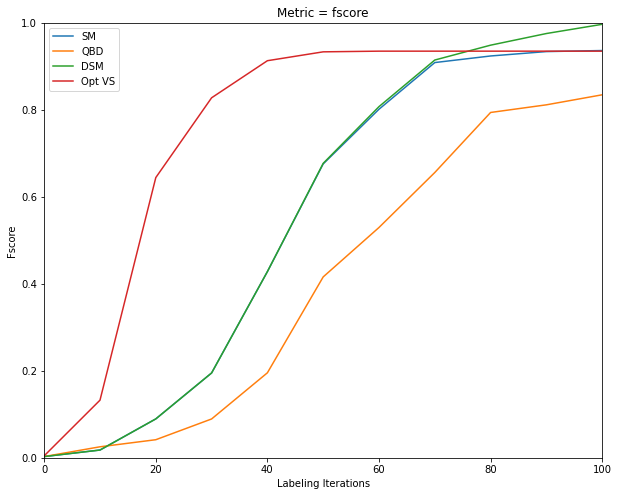

In [5]:
#metric = 'precision'
#metric = 'recall'
metric = 'fscore'
#metric = 'iter_time'


plt.figure(figsize=(10, 8))

for lb, metrics in averaged_metrics.items():
    metrics[metric].plot(label=lb)

if metric in ['precision', 'recall', 'fscore']:
    plt.ylim([0, 1])
    plt.ylabel(metric.capitalize())
else:
    plt.ylim([0, None])
    plt.ylabel('Time per Iteration (s)')
    
    
plt.title("Metric = " + metric)
plt.xlabel('Labeling Iterations')
plt.xlim([0, max(metrics.index)])
plt.legend(loc='best')